In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import dual_annealing

from sklearn.metrics import mean_absolute_percentage_error as mape

import mtpy.core.edi as mtedi

GDAL_DATA environment variable is not set  Please see https://trac.osgeo.org/gdal/wiki/FAQInstallationAndBuilding#HowtosetGDAL_DATAvariable 


Ignore GDAL as it is not working. Will use pyproj


### Функции для решения прямой и обратной задачи, а также вспомогательные функции

In [2]:
mu0 = 4 * np.pi * 1e-7

def calc_effective_Z(z):
    return np.sqrt(z[:, 0, 0] * z[:, 1, 1] - z[:, 1, 0] * z[:, 0, 1])


def forward_1D_MT(rho, h, t): 
    '''
    Функция для решения 1D прямой задачи МТЗ.
    На вход принимает массив сопротивлений слоев и их мощностей (мощностей должно быть на одну меньше, чем сопротивлений),
    а также периодов.
    На выходе возвращает массив комплексный значений импеданса
    '''
    
    w = 2 * np.pi / t  # круговая частота
    R = np.ones(len(t))
    
    mu0 = 4 * np.pi * 1e-7
    
    for m in range(len(h), 0, -1):
        k = np.sqrt(-1j * w * mu0 / rho[m-1])
        
        A = np.sqrt(rho[m-1] / rho[m])
        B = np.exp(-2 * k * h[m - 1]) * (R - A) / (R + A)
        R = (1 + B) / (1 - B)

    k0 = np.sqrt(-1j * w * mu0 / rho[0])
        
    return -1j * w * mu0 * R / k0


    
def calc_app_rho(Z, w_list):
    '''
    Функция, вычисляющая кажущееся сопротивления по значениям импеданса и соответствующих круговых частот
    '''
    
    return np.abs(Z) ** 2 / 2 / np.pi / w_list / mu0



def calc_phase(Z):
    '''
    Функция, вычисляющая фазу по комплексным значениям импеданса
    '''
    
    return np.arctan2(np.imag(Z), np.real(Z)) * 180 / np.pi



def plot_rho(h, rho, max_depth=None):
    '''
    Функция, предназначенная для визуализации 1D разреза сопротивлений.
    На вход принимает мощности слоев и их сопротивления (мощностей, как всегда, на одну меньше, чем сопротивлений)
    На выходе рисует график, на котором по горизонтали откладывается глубина, а по вертикали сопротивления
    '''
    
    hp = np.zeros(len(rho) * 2)
    rhop = np.zeros(len(rho) * 2)
    
    hp[1:-1:2] = np.cumsum(h)
    hp[-1] = np.sum(h) * 1.1 if max_depth is None else max_depth
    hp[2::2] = np.cumsum(h)
    
    rhop[::2] = rho
    rhop[1::2] = rho
    
    plt.loglog(hp, rhop)
    plt.grid(True)
    plt.xlabel('H')
    plt.ylabel(r'$\rho$')

    
    plt.xlim([10 ** np.floor(np.log10(hp[1]) - 1), 10 ** np.ceil(np.log10(hp[-1]))])
    plt.ylim([10 ** np.floor(np.log10(np.min(rho))), 10 ** np.ceil(np.log10(np.max(rho)))])
    


def forward_rmse(section, is_fixed,
                 section_copy,
                 times, obs_Z):
    
    '''
    Вспомогательная функция для инверсии с помощью оптимизаторов из scipy.
    На вход принимает:
    - массив свойств разреза [сопротивление1, мощность1, сопротивление2, мощность2 ...],
    - массив с флагами фиксации того же размера. Если свойство фиксировано, то оно не будет меняться при
    подборе, если не фиксировано, то меняться будет.
    - копия массива свойств разреза (нужно для того, чтобы реализовать фиксацию, иначе scipy будет подбирать 
    все без разбора)
    - периоды
    - наблюденные значения импеданса
    
    '''
        
    rho = section_copy[0::2]
    h = section_copy[1::2]
    
    for i, (r, fixed) in enumerate(zip(section[::2], is_fixed[::2])):
        if not fixed:
            rho[i] = r
            
    for i, (h_layer, fixed) in enumerate(zip(section[1::2], is_fixed[1::2])):
        if not fixed:
            h[i] = h_layer

    Z = forward_1D_MT(rho, h, times)
    
    delta_real = np.log(np.abs(np.real(obs_Z))) - np.log(np.abs(np.real(Z)))
    delta_imag = np.log(np.abs(np.imag(obs_Z))) - np.log(np.abs(np.imag(Z)))
    delta = (np.sum(delta_real ** 2) + np.sum(delta_imag ** 2)) / len(Z)
    #delta = np.sum((np.abs(Z) - np.abs(obs_Z)) ** 2)
    
    
    return delta
    

def get_z_from_edi(edi, component='eff'):
    z = []
    
    if component == 'eff':
        z = calc_effective_Z(edi.Z.z) * (mu0 * np.sqrt(1e6))
    elif component == 'xy':
        z = edi.Z.z[:, 0, 1] * (mu0 * np.sqrt(1e6))
    elif component == 'yx':
        z = edi.Z.z[:, 1, 0] * (mu0 * np.sqrt(1e6))

    if len(z):
        z = np.conjugate(z)
        t_list = 1 / edi.Z.freq
        
        t_list = t_list[np.logical_and(np.abs(z) > 0, np.imag(z) < 0)]
        z = z[np.logical_and(np.abs(z) > 0, np.imag(z) < 0)]
        
        return t_list, z
    
    
    
def fit_1d_model(rho_init, h_init, is_fixed_rho, is_fixed_h, Z_obs, t_list,
                 N_iter=10, method='CG', min_res=1e-9, max_res=1e50, min_h=1e-9, max_h=1e50):
    
    
    '''
    Функция для автоматического подбора (инверсии) 1D разреза сопротивлений.
    На вход принимает:
    - массив стартовых значений сопротивлений
    - массив стартовых значений мощностей (как и всегда, их должно быть на одно меньше, чем сопротивлений)
    - массив с флагами фиксации сопротивлений (True - сопротивление фиксировано и не должно меняться, False - нужно подбирать)
    - массив с флагами фиксации мощностей (аналогично сопротивлению)
    - массив наблюденных значений импеданса
    - массив периодов
    - количество итераций
    - метод оптимизации (см scipy.optimize.minimize)
    
    На выходе выдает массив подобранных сопротивлений и массив подобранных мощностей
    '''
    
    sect = np.empty(len(ro_init) + len(h_init))
    sect[::2] = ro_init
    sect[1::2] = h_init

    is_fixed = np.zeros(len(sect)) 
    is_fixed[::2] = is_fixed_rho
    is_fixed[1::2] = is_fixed_h
    is_fixed = is_fixed.astype('bool')
    
    init_sect = sect.copy()

    for n in range(N_iter):
        res = minimize(forward_rmse, sect, args=(is_fixed, init_sect, t_list, Z_obs), 
                       method=method, options={'maxiter': 50})

        out_sect = res.x
        new_sect = sect.copy()
        new_sect[~is_fixed] = out_sect[~is_fixed]
        
        sect = new_sect.copy()
        
        for i in range(1, len(sect), 2):
            if sect[i] < min_h:
                sect[i] = min_h
            elif sect[i] > max_h:
                sect[i] = max_h
                
        for i in range(0, len(sect), 2):
            if sect[i] < min_res:
                sect[i] = min_res
            elif sect[i] > max_res:
                sect[i] = max_res
        
            
    new_sect = init_sect.copy()
    new_sect[~is_fixed] = sect[~is_fixed]


    h_out = new_sect[1::2]
    rho_out = new_sect[::2]
    
    return rho_out, h_out
    
    

    

#### Создаем тестовую модель и импортируем список периодов

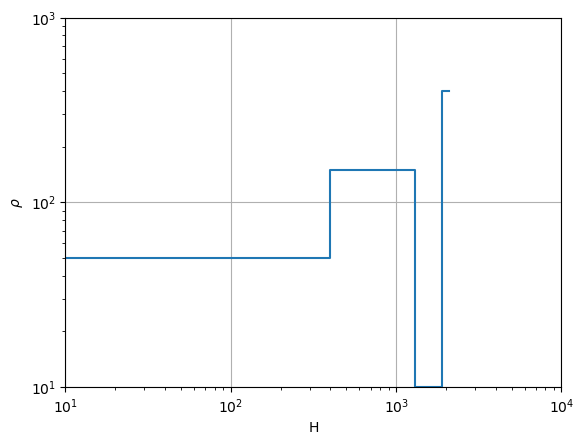

In [3]:
Ro_list = np.array([50, 150, 10, 400])
H_list = np.array([400, 900, 600])

t_list = np.loadtxt('Data/t_list.txt')
w_list = 2 * np.pi / t_list

plot_rho(H_list, Ro_list)

#### Решаем прямую задачу

Text(0, 0.5, '$\\rho_\\tau$')

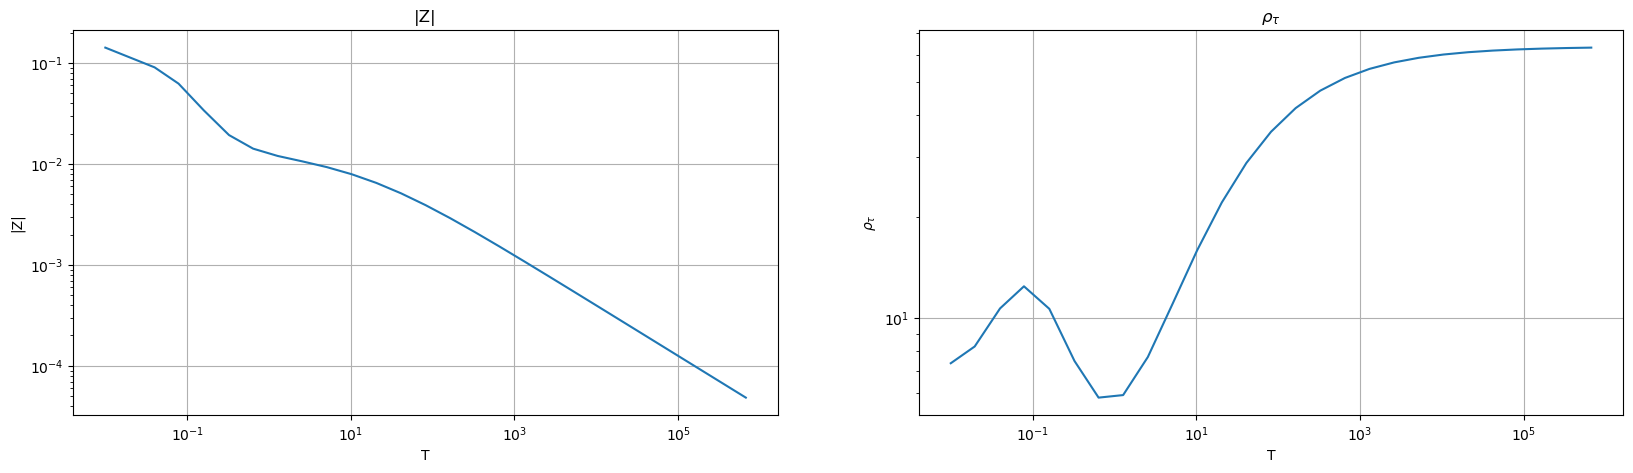

In [4]:
Z = forward_1D_MT(Ro_list, H_list, t_list)
app_rho = calc_app_rho(Z, w_list)


fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.loglog(t_list, np.real(Z))
ax1.set_title('|Z|')
ax1.grid(True)
ax1.set_xlabel('T')
ax1.set_ylabel('|Z|')

ax2.loglog(t_list, app_rho)
ax2.set_title(r'$\rho_\tau$')
ax2.grid(True)
ax2.set_xlabel('T')
ax2.set_ylabel(r'$\rho_\tau$')

#### Создаем стартовую модель для инверсии

C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:75: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([10 ** np.floor(np.log10(np.min(rho))), 10 ** np.ceil(np.log10(np.max(rho)))])


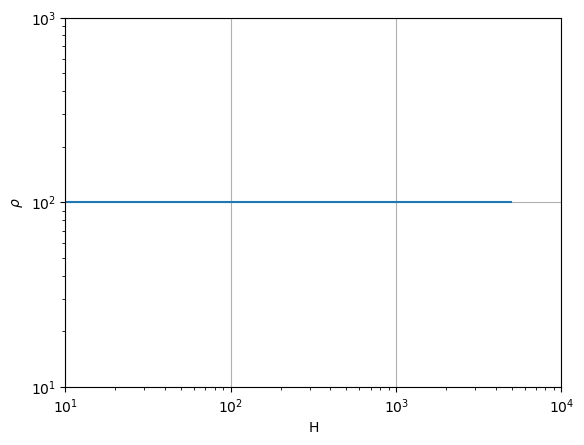

In [5]:
ro_init  = np.ones(10) * 100
h_init = np.ones(len(ro_init) - 1) * 500

is_fixed_ro = np.zeros(len(ro_init)) # все сопротивления не фиксированы
is_fixed_h = np.zeros(len(h_init)) # все мощности не фиксированы

plot_rho(h_init, ro_init)

#### Подбираем сопротивления и мощности

In [6]:
ro_out, h_out = fit_1d_model(ro_init, h_init, is_fixed_ro, is_fixed_h, Z, t_list)

#### Сравниваем прямую задачу для подобранной и реальной моделей, а также сами модели

Text(0.5, 1.0, '$\\rho$')

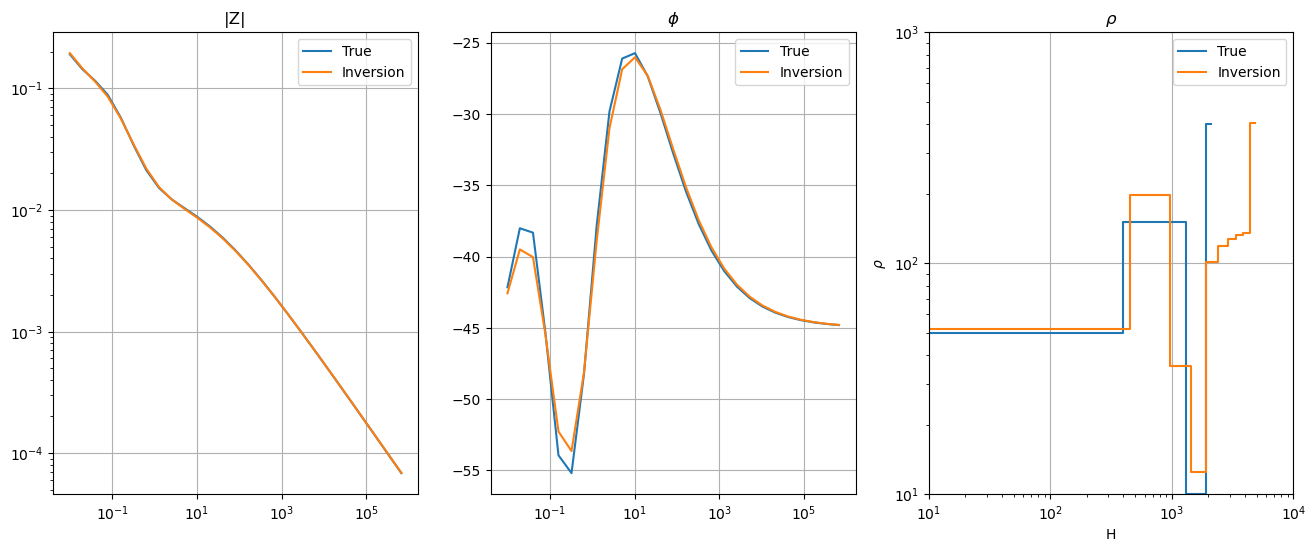

In [7]:
Z_inv = forward_1D_MT(ro_out, h_out, t_list)

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(1, 3, 1)
ax1.loglog(t_list, np.abs(Z))
ax1.loglog(t_list, np.abs(Z_inv))
ax1.grid(True)
ax1.legend(['True', 'Inversion'])
ax1.set_title('|Z|')


ax2 = fig.add_subplot(1, 3, 2)
ax2.semilogx(t_list, calc_phase(Z))
ax2.semilogx(t_list, calc_phase(Z_inv))
ax2.grid(True)
ax2.legend(['True', 'Inversion'])
ax2.set_title(r'$\phi$')


ax3 = fig.add_subplot(1, 3, 3)
plot_rho(H_list, Ro_list)
plot_rho(h_out, ro_out)
ax3.grid(True)
ax3.legend(['True', 'Inversion'])
ax3.set_title(r'$\rho$')


#### Оцениваем ошибку

In [8]:
print('|Z| error = ', mape(np.log(np.abs(Z)), np.log(np.abs(Z_inv))) * 100, ' %')
print('Re(Z) error = ', mape(np.log(np.real(Z)), np.log(np.real(Z_inv))) * 100, ' %')
print('Im(Z) error = ', mape(np.log(-np.imag(Z)), np.log(-np.imag(Z_inv))) * 100, ' %')

|Z| error =  0.31421939020456907  %
Re(Z) error =  0.3315732315540831  %
Im(Z) error =  0.40809358760226044  %


## Тест на реальных данных

#### Читаем файл

In [11]:
edi = mtedi.Edi()
edi.read_edi_file('data/norm/03_1.edi')

C:\Users\chepi\anaconda3\lib\site-packages\mtpy\utils\calculator.py:365: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


#### Создаем стартовую модель

In [12]:
mod = np.loadtxt('Model_016_KC.txt', skiprows=2)
ro_init = mod[:, 0]
h_init = mod[:-1, 1]

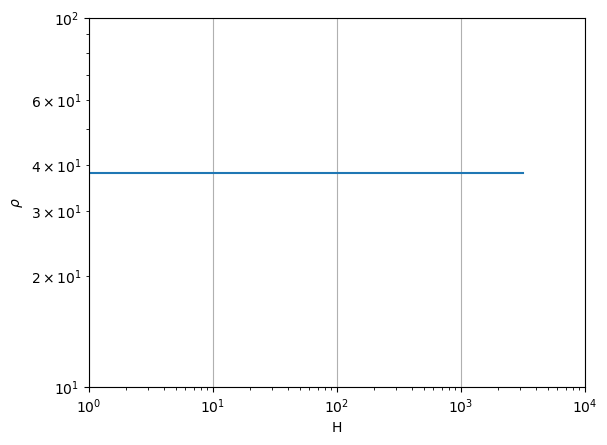

In [10]:
ro_init  = np.ones(10) * 37.96
h_init = np.array([30, 47, 73, 110, 180, 280, 430, 670, 1050])


is_fixed_ro = np.zeros(len(ro_init)) # все сопротивления не фиксированы
is_fixed_h = np.zeros(len(h_init)) # все мощности не фиксированы


plot_rho(h_init, ro_init)

#### Достаем из EDI файла нужную нам компоненту

In [11]:
t_list, Z = get_z_from_edi(edi, component='eff')

#### Подбираем модель

In [12]:
ro_out, h_out = fit_1d_model(ro_init, h_init, is_fixed_ro, is_fixed_h, Z, t_list, N_iter = 10, method='CG',
                             min_res=1, max_res=250)

C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:23: RuntimeWarning: invalid value encountered in sqrt
  A = np.sqrt(rho[m-1] / rho[m])
C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:24: RuntimeWarning: invalid value encountered in divide
  B = np.exp(-2 * k * h[m - 1]) * (R - A) / (R + A)
C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:25: RuntimeWarning: invalid value encountered in divide
  R = (1 + B) / (1 - B)
C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:23: RuntimeWarning: invalid value encountered in sqrt
  A = np.sqrt(rho[m-1] / rho[m])
C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:24: RuntimeWarning: invalid value encountered in divide
  B = np.exp(-2 * k * h[m - 1]) * (R - A) / (R + A)
C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:25: RuntimeWarning: invalid value encountered in divide
  R = (1 + B) / (1 - B)
C:\Users\chepi\AppData\Local\Temp\ipykernel_9520\557660168.py:24: RuntimeWarni

#### Просмотр результатов

Text(0.5, 1.0, '$\\rho$')

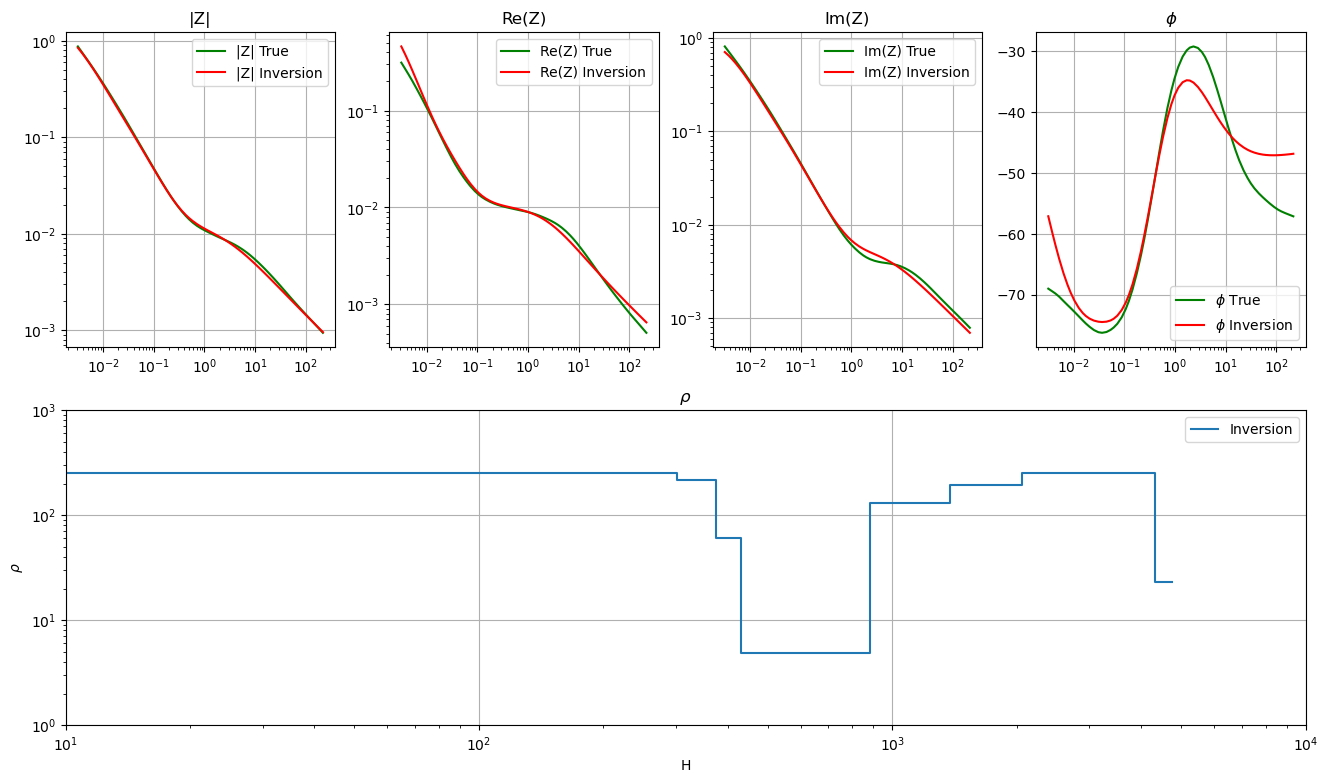

In [13]:
Z_inv = forward_1D_MT(ro_out, h_out, t_list)

fig = plt.figure(figsize=(16, 9))

gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax1.loglog(t_list, np.abs(Z), 'g')
ax1.loglog(t_list, np.abs(Z_inv), 'r')
ax1.grid(True)
ax1.legend(['|Z| True', '|Z| Inversion', 'Re(Z) True', 'Re(Z) Inversion', 'Im(Z) True', 'Im(Z) Inversion'])
ax1.set_title('|Z|')


ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(t_list, np.real(Z), 'g')
ax2.loglog(t_list, np.real(Z_inv), 'r')
ax2.grid(True)
ax2.legend(['Re(Z) True', 'Re(Z) Inversion'])
ax2.set_title('Re(Z)')


ax3 = fig.add_subplot(gs[0, 2])
ax3.loglog(t_list, -np.imag(Z), 'g')
ax3.loglog(t_list, -np.imag(Z_inv), 'r')
ax3.grid(True)
ax3.legend(['Im(Z) True', 'Im(Z) Inversion'])
ax3.set_title('Im(Z)')


ax4 = fig.add_subplot(gs[0, 3])
ax4.semilogx(t_list, calc_phase(Z), 'g')
ax4.semilogx(t_list, calc_phase(Z_inv), 'r')
ax4.grid(True)
ax4.legend([r'$\phi$ True', r'$\phi$ Inversion'])
ax4.set_title(r'$\phi$')


ax5 = fig.add_subplot(gs[1, :])
plot_rho(h_out, ro_out)
ax5.grid(True)
ax5.legend(['Inversion'])
ax5.set_title(r'$\rho$')

In [14]:
df = pd.DataFrame()
df['Res'] = ro_out
df['H'] = np.nan
df['H'].loc[0:len(h_out)-1] = h_out
df

,Res,H
0,250.000000,172.409965
1,250.000000,129.669253
2,214.092794,72.828973
3,60.916527,55.185316
4,4.895374,451.257263
5,129.414668,499.257312
6,194.163948,680.407122
7,250.000000,933.459939
8,250.000000,1321.247651
9,22.891344,NaN


In [ ]:
df.to_csv('result.csv')

#### Оцениваем ошибку

In [15]:
print('|Z| error = ', mape(np.log(np.abs(Z)), np.log(np.abs(Z_inv))) * 100, ' %')
print('Re(Z) error = ', mape(np.log(np.real(Z)), np.log(np.real(Z_inv))) * 100, ' %')
print('Im(Z) error = ', mape(np.log(-np.imag(Z)), np.log(-np.imag(Z_inv))) * 100, ' %')

|Z| error =  1.6049873258303495  %
Re(Z) error =  3.129384787298621  %
Im(Z) error =  3.7656469813964506  %
